# Tarea 05 - Imágenes Generativas
## Detección de Anomalías en Imágenes Industriales

Este notebook implementa un sistema de detección de anomalías usando el dataset MVTec AD.


In [18]:
# Instalación de dependencias necesarias
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install matplotlib numpy scikit-learn opencv-python pillow tqdm


Looking in indexes: https://download.pytorch.org/whl/cu118


In [19]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Configuración de rutas
# Ajusta esta ruta según donde tengas el dataset en tu Google Drive
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset'  # Ajusta según tu estructura

# Categorías disponibles
CATEGORIES = ['cable', 'capsule', 'screw', 'transistor']

# Selecciona la categoría a trabajar (puedes cambiar esto)
SELECTED_CATEGORY = 'cable'  # Cambia a 'capsule', 'screw', o 'transistor' según necesites

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, average_precision_score
import cv2

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')


Usando dispositivo: cpu


## 1. Carga y Preprocesamiento de Datos


In [21]:
class AnomalyDataset(Dataset):
    """Dataset para cargar imágenes de entrenamiento y prueba"""

    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

def load_dataset_paths(category_path, split='train'):
    """Carga las rutas de las imágenes del dataset"""
    paths = []
    split_path = os.path.join(category_path, split)

    if split == 'train':
        # Solo imágenes 'good' en entrenamiento
        good_path = os.path.join(split_path, 'good')
        if os.path.exists(good_path):
            for img_file in os.listdir(good_path):
                if img_file.endswith('.png'):
                    paths.append(os.path.join(good_path, img_file))
    else:
        # En test, cargar todas las clases (good y defectos)
        if os.path.exists(split_path):
            for class_name in os.listdir(split_path):
                class_path = os.path.join(split_path, class_name)
                if os.path.isdir(class_path):
                    for img_file in os.listdir(class_path):
                        if img_file.endswith('.png'):
                            paths.append(os.path.join(class_path, img_file))

    return paths

# Cargar rutas del dataset
category_path = os.path.join(DATASET_PATH, SELECTED_CATEGORY)
train_paths = load_dataset_paths(category_path, split='train')
test_paths = load_dataset_paths(category_path, split='test')

print(f'Imágenes de entrenamiento: {len(train_paths)}')
print(f'Imágenes de prueba: {len(test_paths)}')


Imágenes de entrenamiento: 224
Imágenes de prueba: 150


In [22]:
# Transformaciones de datos
image_size = 256

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets
train_dataset = AnomalyDataset(train_paths, transform=train_transform)
test_dataset = AnomalyDataset(test_paths, transform=test_transform)

# Crear dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Batches de entrenamiento: {len(train_loader)}')
print(f'Batches de prueba: {len(test_loader)}')


Batches de entrenamiento: 7
Batches de prueba: 5


## 2. Definición del Modelo - Autoencoder


In [23]:
class Autoencoder(nn.Module):
    """Autoencoder para detección de anomalías"""

    def __init__(self, input_channels=3, latent_dim=128):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # 256x256 -> 128x128
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            # 128x128 -> 64x64
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            # 64x64 -> 32x32
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            # 32x32 -> 16x16
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            # 16x16 -> 8x8
            nn.Conv2d(512, latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            # 8x8 -> 16x16
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            # 32x32 -> 64x64
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            # 64x64 -> 128x128
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            # 128x128 -> 256x256
            nn.ConvTranspose2d(64, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Crear modelo
model = Autoencoder(input_channels=3, latent_dim=128).to(device)
print(f'Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros')


Modelo creado con 7614211 parámetros


## 3. Entrenamiento del Modelo


In [24]:
# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Función de entrenamiento
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch_idx, images in enumerate(train_loader):
        images = images.to(device)

        # Forward pass
        optimizer.zero_grad()
        reconstructed = model(images)
        loss = criterion(reconstructed, images)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    return total_loss / len(train_loader)

# Entrenar modelo
num_epochs = 20
train_losses = []

print('Iniciando entrenamiento...')
for epoch in range(num_epochs):
    print(f'\nÉpoca {epoch+1}/{num_epochs}')
    avg_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(avg_loss)
    scheduler.step()
    print(f'Pérdida promedio: {avg_loss:.4f}')

print('\nEntrenamiento completado!')


Iniciando entrenamiento...

Época 1/20
Batch 0/7, Loss: 1.4720
Pérdida promedio: 1.1534

Época 2/20
Batch 0/7, Loss: 0.9440
Pérdida promedio: 0.8446

Época 3/20
Batch 0/7, Loss: 0.7298
Pérdida promedio: 0.6834

Época 4/20
Batch 0/7, Loss: 0.6171
Pérdida promedio: 0.5756

Época 5/20
Batch 0/7, Loss: 0.5277
Pérdida promedio: 0.5121

Época 6/20
Batch 0/7, Loss: 0.5005
Pérdida promedio: 0.4797

Época 7/20
Batch 0/7, Loss: 0.4683
Pérdida promedio: 0.4566

Época 8/20
Batch 0/7, Loss: 0.4499
Pérdida promedio: 0.4336

Época 9/20
Batch 0/7, Loss: 0.4144
Pérdida promedio: 0.4037

Época 10/20
Batch 0/7, Loss: 0.3896
Pérdida promedio: 0.3821

Época 11/20
Batch 0/7, Loss: 0.3675
Pérdida promedio: 0.3677

Época 12/20
Batch 0/7, Loss: 0.3581
Pérdida promedio: 0.3564

Época 13/20
Batch 0/7, Loss: 0.3499
Pérdida promedio: 0.3449

Época 14/20
Batch 0/7, Loss: 0.3274
Pérdida promedio: 0.3332

Época 15/20
Batch 0/7, Loss: 0.3238
Pérdida promedio: 0.3217

Época 16/20
Batch 0/7, Loss: 0.3096
Pérdida promedi

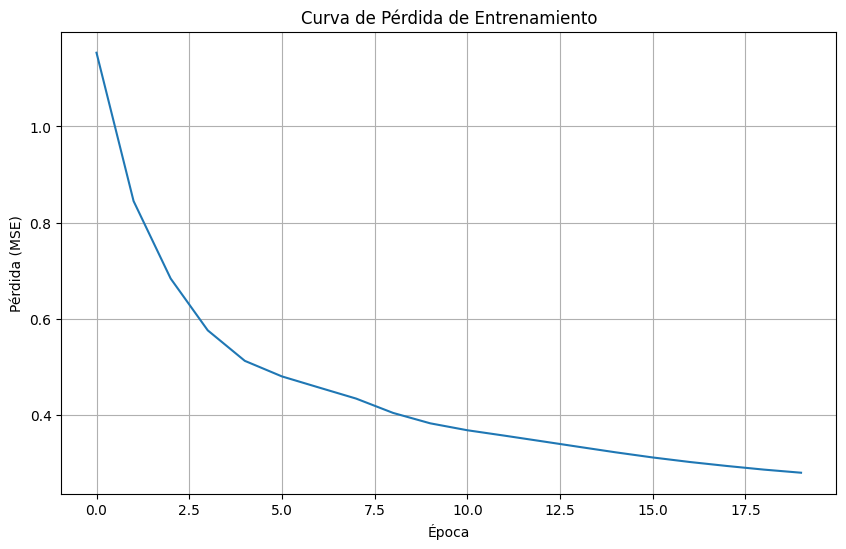

In [25]:
# Visualizar curva de pérdida
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Curva de Pérdida de Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.grid(True)
plt.show()


## 4. Evaluación y Detección de Anomalías


In [26]:
def get_anomaly_labels(test_paths, category_path):
    """Obtiene las etiquetas de anomalía (0=normal, 1=anomalía)"""
    labels = []
    good_path = os.path.join(category_path, 'test', 'good')

    for path in test_paths:
        if good_path in path:
            labels.append(0)  # Normal
        else:
            labels.append(1)  # Anomalía

    return np.array(labels)

# Obtener etiquetas de prueba
test_labels = get_anomaly_labels(test_paths, category_path)
print(f'Imágenes normales: {np.sum(test_labels == 0)}')
print(f'Imágenes con anomalías: {np.sum(test_labels == 1)}')


Imágenes normales: 58
Imágenes con anomalías: 92


In [27]:
# Evaluar modelo en datos de prueba
model.eval()
anomaly_scores = []
sample_images = []
sample_reconstructions = []

with torch.no_grad():
    for batch_idx, images in enumerate(test_loader):
        images = images.to(device)
        reconstructed = model(images)

        # Calcular error de reconstrucción (MSE) como score de anomalía
        mse = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
        anomaly_scores.extend(mse.cpu().numpy())

        # Guardar algunas muestras para visualización
        if batch_idx == 0:
            sample_images = images[:10].cpu()
            sample_reconstructions = reconstructed[:10].cpu()

anomaly_scores = np.array(anomaly_scores)
print(f'Rango de scores: [{anomaly_scores.min():.4f}, {anomaly_scores.max():.4f}]')


Rango de scores: [0.1947, 0.3850]


AUC-ROC: 0.6139
Average Precision: 0.6987


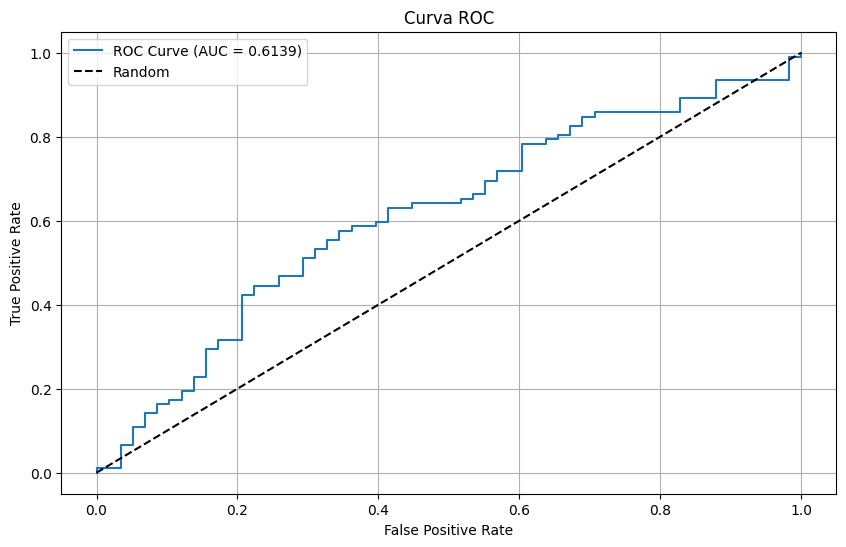

In [28]:
# Calcular métricas
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

auc_score = roc_auc_score(test_labels, anomaly_scores)
ap_score = average_precision_score(test_labels, anomaly_scores)

print(f'AUC-ROC: {auc_score:.4f}')
print(f'Average Precision: {ap_score:.4f}')

# Curva ROC
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()


## 5. Visualización de Resultados


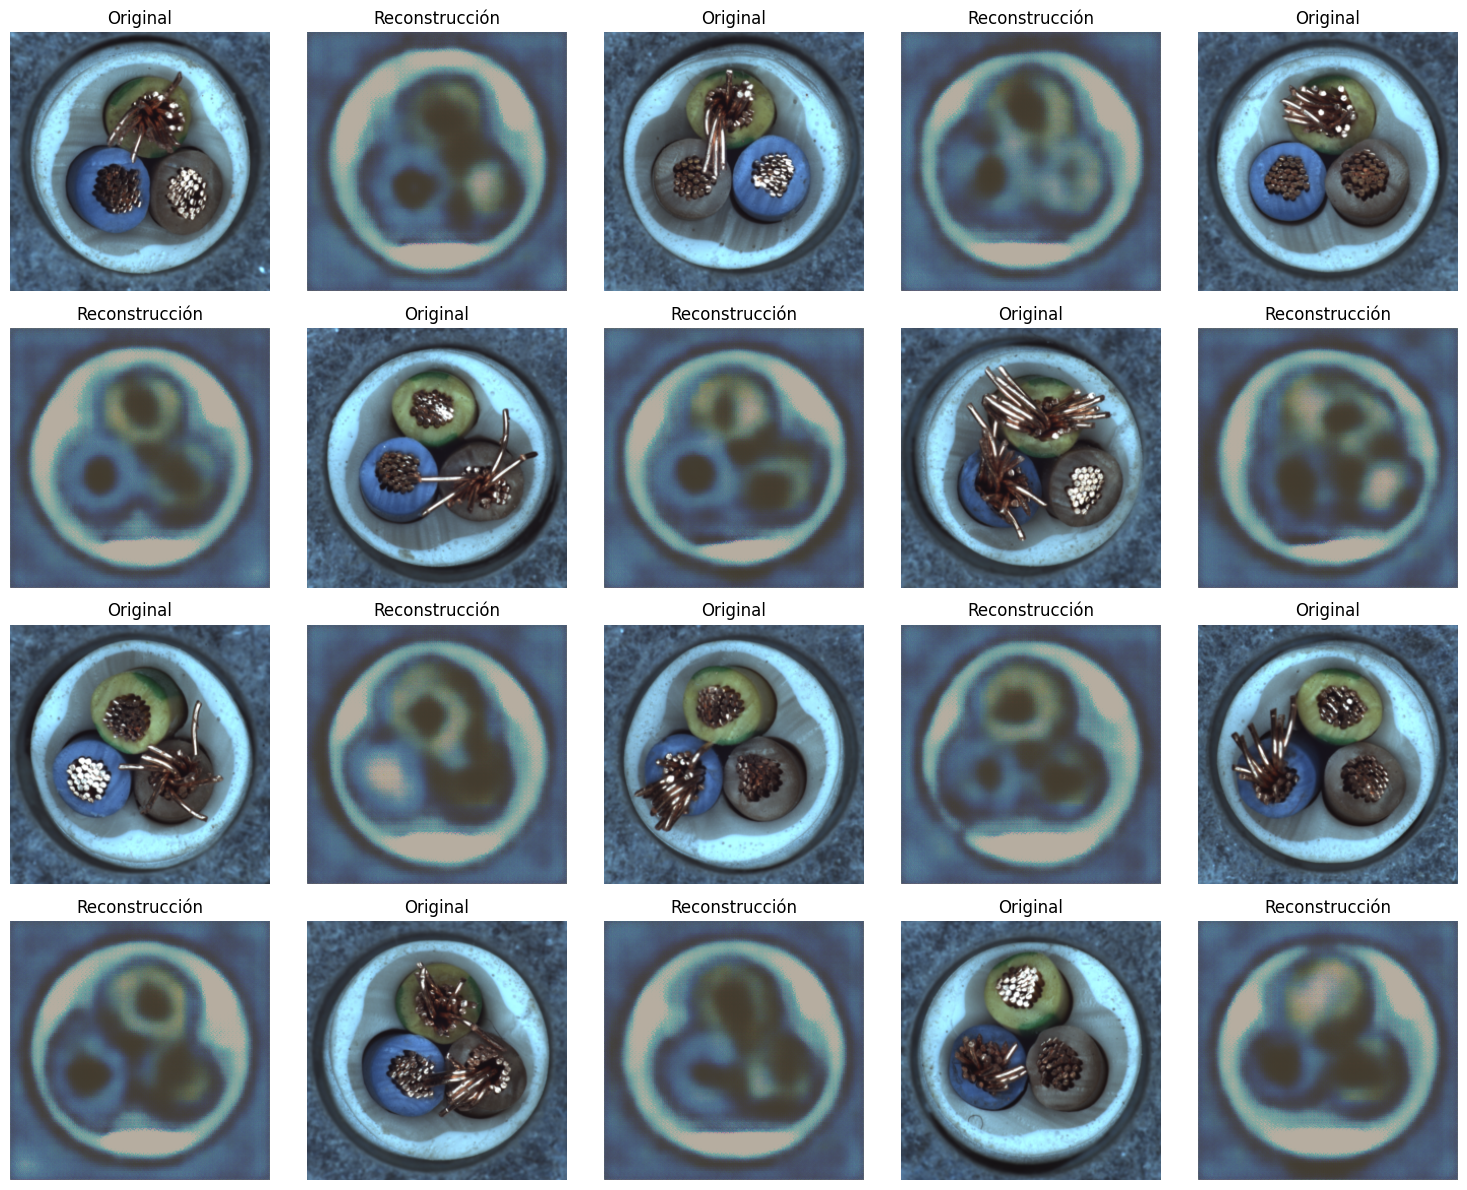

In [29]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Desnormaliza un tensor de imagen"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)

# Visualizar reconstrucciones
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(min(10, len(sample_images))):
    # Imagen original
    img = denormalize(sample_images[i].clone())
    axes[i*2].imshow(img.permute(1, 2, 0))
    axes[i*2].set_title('Original')
    axes[i*2].axis('off')

    # Reconstrucción
    recon = denormalize(sample_reconstructions[i].clone())
    axes[i*2+1].imshow(recon.permute(1, 2, 0))
    axes[i*2+1].set_title('Reconstrucción')
    axes[i*2+1].axis('off')

plt.tight_layout()
plt.show()


/tmp/ipython-input-2567677690.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_scores, anomaly_scores_plot], labels=['Normal', 'Anomalía'])


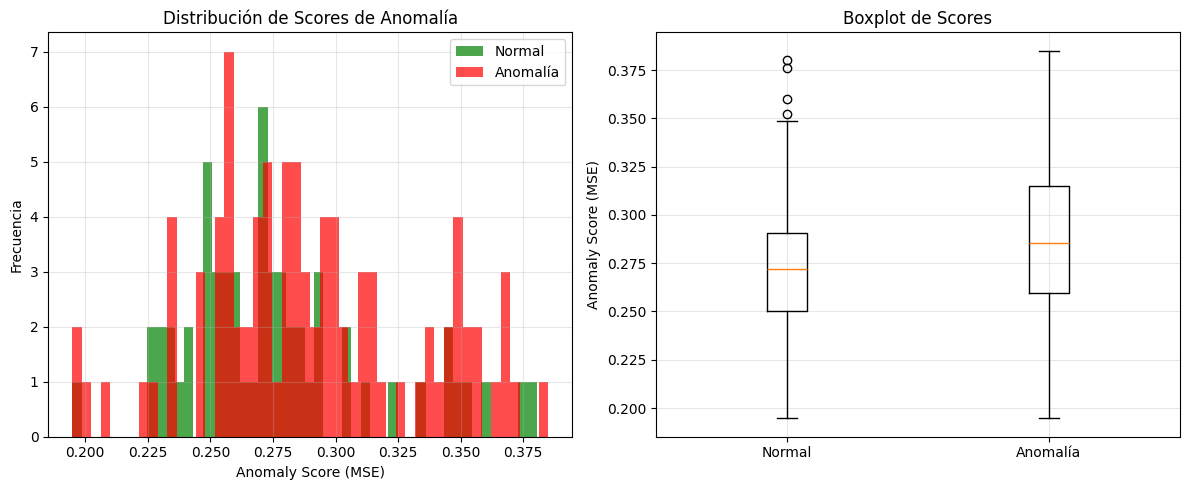

In [30]:
# Visualizar distribución de scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
normal_scores = anomaly_scores[test_labels == 0]
anomaly_scores_plot = anomaly_scores[test_labels == 1]
plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal', color='green')
plt.hist(anomaly_scores_plot, bins=50, alpha=0.7, label='Anomalía', color='red')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Scores de Anomalía')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([normal_scores, anomaly_scores_plot], labels=['Normal', 'Anomalía'])
plt.ylabel('Anomaly Score (MSE)')
plt.title('Boxplot de Scores')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [31]:
# Encontrar mejores y peores reconstrucciones
sorted_indices = np.argsort(anomaly_scores)

print("Top 5 imágenes con menor error (más normales):")
for idx in sorted_indices[:5]:
    print(f"  {test_paths[idx]} - Score: {anomaly_scores[idx]:.4f}")

print("\nTop 5 imágenes con mayor error (más anómalas):")
for idx in sorted_indices[-5:]:
    print(f"  {test_paths[idx]} - Score: {anomaly_scores[idx]:.4f}")


Top 5 imágenes con menor error (más normales):
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/poke_insulation/001.png - Score: 0.1947
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/good/054.png - Score: 0.1949
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/combined/007.png - Score: 0.1968
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/poke_insulation/008.png - Score: 0.2012
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/missing_wire/007.png - Score: 0.2087

Top 5 imágenes con mayor error (más anómalas):
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/cut_outer_insulation/004.png - Score: 0.3690
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/cut_outer_insulation/007.png - Score: 0.3711
  /content/drive/MyDrive/Colab Notebooks/Tarea5-IA/dataset/cable/test/good/033.png - Score: 0.3762
  /content/drive/MyDrive/Colab Notebooks/Tarea5

## 6. Guardar Modelo


In [32]:
# Guardar modelo entrenado
model_save_path = '/content/drive/MyDrive/Tarea5-IA/modelo_autoencoder.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'auc_score': auc_score,
    'ap_score': ap_score
}, model_save_path)

print(f'Modelo guardado en: {model_save_path}')


RuntimeError: Parent directory /content/drive/MyDrive/Tarea5-IA does not exist.

## Notas Finales

- El modelo ha sido entrenado solo con imágenes normales (good)
- Las anomalías se detectan mediante el error de reconstrucción
- Puedes ajustar el umbral de detección según tus necesidades
- Para cargar el modelo guardado, usa: `torch.load(model_save_path)`
